<a href="https://colab.research.google.com/github/pankaj90382/TSAI/blob/master/S7/S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !rm -r /content/Dataset/
# !rm -r /content/tensorboard/

In [1]:
!nvidia-smi

Sun May 24 19:54:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#load dataset into the colab
path='/content/drive/My Drive/Colab Notebooks/'
# Extracting the data by 7zipper
!7z x '{path}'/bg.7z -o'/content/Dataset/bg'
!7z x '{path}'/fgbg.7z -o'/content/Dataset/fgbg'
!7z x '{path}'/fgbgmask.7z -o'/content/Dataset/fgbgmask/'
!7z x '{path}'/Densedepth.7z -o'/content/Dataset/dense'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/Colab Notebooks//                                                   1 file, 2286969 bytes (2234 KiB)

Extracting archive: /content/drive/My Drive/Colab Notebooks//bg.7z
--
Path = /content/drive/My Drive/Colab Notebooks//bg.7z
Type = 7z
Physical Size = 2286969
Headers Size = 1341
Method = LZMA2:3m
Solid = +
Blocks = 1

  0%    Everything is Ok

Files: 100
Size:       2341905
Compressed: 2286969

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archive

In [0]:
import sys
S15_PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/S15'
sys.path.append(S15_PROJECT_PATH+'/S15_Modular_Code/')
import os
os.chdir(S15_PROJECT_PATH+'/S15_Modular_Code/')

In [0]:
from __future__ import print_function
import torch
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np
from utils import *
from torch.utils.tensorboard import SummaryWriter

#Dataloader Arguments & Test/Train Dataloaders


In [0]:
from torchDataset import SchoolDataset
from PIL import Image
from matplotlib import pyplot as plt

In [0]:
from pathlib import Path
data_root=Path('/content/Dataset')

In [9]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"
from Album_Methods import Albumentations as AM

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-8052bvqb
All libraries are successfully installed!


In [0]:
fgbg_train_transform = AM().transform(**{
    'Normalize': {'mean': (0.49641467, 0.50198746, 0.48275208), 'std':(0.2798614 , 0.27848746, 0.31762387)},
    #'Resize':{'height':128, 'width':128},
    #'ShiftScaleRotate' : {'shift_limit':0.0625, 'scale_limit':0.2, 'rotate_limit':(-10,10), 'p':.2},
    #'RandomBrightnessContrast':{'brightness_limit':0.2, 'contrast_limit':0.2, 'brightness_by_max':False},
    #'HueSaturationValue':{'hue_shift_limit':0.1, 'sat_shift_limit':0.1, 'val_shift_limit':0, 'p':0.2},
    #'GridDistortion' : {'num_steps':5},
    #'RandomRotate90' : {},
    #'ToGray':{'always_apply'=True},
    'ToTensor':{}
})

bg_train_transform = AM().transform(**{
    'Normalize': {'mean': (0.49836101, 0.50576683, 0.48631948), 'std':(0.27918635, 0.27833673, 0.31944063)},
    #'Resize':{'height':128, 'width':128},
    #'ShiftScaleRotate' : {'shift_limit':0.0625, 'scale_limit':0.2, 'rotate_limit':(-10,10), 'p':.2},
    #'RandomBrightnessContrast':{'brightness_limit':0.2, 'contrast_limit':0.2, 'brightness_by_max':False},
    #'HueSaturationValue':{'hue_shift_limit':0.1, 'sat_shift_limit':0.1, 'val_shift_limit':0, 'p':0.2},
    #'GridDistortion' : {'num_steps':5},
    #'RandomRotate90' : {},
    #'ToGray':{'always_apply'=True},
    'ToTensor':{}
})

mask_train_transform = AM().transform(**{
    'Normalize': {'mean': (0.05250582), 'std':(0.22033702)},
    #'Resize':{'height':128, 'width':128},
    #'ShiftScaleRotate' : {'shift_limit':0.0625, 'scale_limit':0.2, 'rotate_limit':(-10,10), 'p':.2},
    #'RandomBrightnessContrast':{'brightness_limit':0.2, 'contrast_limit':0.2, 'brightness_by_max':False},
    #'HueSaturationValue':{'hue_shift_limit':0.1, 'sat_shift_limit':0.1, 'val_shift_limit':0, 'p':0.2},
    #'GridDistortion' : {'num_steps':5},
    #'RandomRotate90' : {},
    'ToTensor':{}
})

depth_train_transform = AM().transform(**{
    'Normalize': {'mean': (0.41627218), 'std':(0.25850094)},
    #'Resize':{'height':128, 'width':128},
    #'ShiftScaleRotate' : {'shift_limit':0.0625, 'scale_limit':0.2, 'rotate_limit':(-10,10), 'p':.2},
    #'RandomBrightnessContrast':{'brightness_limit':0.2, 'contrast_limit':0.2, 'brightness_by_max':False},
    #'HueSaturationValue':{'hue_shift_limit':0.1, 'sat_shift_limit':0.1, 'val_shift_limit':0, 'p':0.2},
    #'GridDistortion' : {'num_steps':5},
    #'RandomRotate90' : {},
    'ToTensor':{}
})

In [0]:
fgbg_test_transform = AM().transform(**{
    'Normalize': {'mean': (0.49641467, 0.50198746, 0.48275208), 'std':(0.2798614 , 0.27848746, 0.31762387)},
    #'Resize':{'height':128, 'width':128},
    'ToTensor':{}
})

bg_test_transform = AM().transform(**{
    'Normalize': {'mean': (0.49836101, 0.50576683, 0.48631948), 'std':(0.27918635, 0.27833673, 0.31944063)},
    #'Resize':{'height':128, 'width':128},
    'ToTensor':{}
})

mask_test_transform = AM().transform(**{
    'Normalize': {'mean': (0.05250582), 'std':(0.22033702)},
    #'Resize':{'height':128, 'width':128},
    'ToTensor':{}
})

depth_test_transform = AM().transform(**{
    'Normalize': {'mean': (0.41627218), 'std':(0.25850094)},
    #'Resize':{'height':128, 'width':128},
    'ToTensor':{}
})

In [0]:
train_transform={'bg':bg_train_transform,'fgbg':fgbg_train_transform, 'fgbg_mask':mask_train_transform, 'fgbg_dense':depth_train_transform}
test_transform={'bg':bg_test_transform,'fgbg':fgbg_test_transform, 'fgbg_mask':mask_test_transform, 'fgbg_dense':depth_test_transform}

In [13]:
from DataLoader import DataLoader

SEED = 1

# reading filenames
filenames=list(map(lambda x:x.relative_to(data_root/'fgbg'), (data_root/'fgbg').rglob('*.jpg')))

# Splitting Dataset into train and test
from sklearn.model_selection import train_test_split
train_names, test_names = train_test_split(filenames, train_size=0.99, test_size=0.01, shuffle=True)

# Downloading TrainSet
trainset = SchoolDataset(data_root, train_names, transform=train_transform)

# Downloading Testset
testset = SchoolDataset(data_root, test_names, transform=test_transform)

# Creating object of a class
dataloader= DataLoader(shuffle=False, batch_size=32, seed=SEED, num_workers=2, pin_memory=True)


# split trainset data according to S15 Requirements
#trainset,testset = torch.utils.data.random_split(trainset, [int(.70*len(trainset)), int(.30*len(trainset))]) 

# train data loader
trainloader = dataloader.load(trainset)

# test data loader
testloader = dataloader.load(testset)

CUDA Available? True


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
name="Model_Unet_Exp6"

In [0]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('/content/tensorboard/'+name)

In [17]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir '/content/tensorboard/{name}'

Output hidden; open in https://colab.research.google.com to view.

Let us show some of the training images, for fun.



2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [18]:
import torch.nn as nn
import torch.nn.functional as F
from Model import UnetExp
model = UnetExp(name=name)
model.to(dataloader.device)
model.summary(input_size=[(3, 64, 64),(3, 64, 64)])
#model.summary(input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             864
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          36,864
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]          82,944
      BatchNorm2d-11           [-1, 96, 64, 64]             192
             ReLU-12           [-1, 96, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         442,368
      BatchNorm2d-14          [-1, 256,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
torch.cuda.empty_cache()

In [0]:
# # ...log a Matplotlib Figure showing the model's predictions on a
#             # random mini-batch
# writer.add_figure('Epoch Images', plot_classes_preds(net, inputs, labels), global_step=epoch * len(trainloader) + i)

In [0]:
model.modelload(S15_PROJECT_PATH+"/Save_Model/Model_Unet_Exp4.pt")

In [22]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
#from LRFinder import LR_Finder
Loss="MSELoss"
EPOCHS = 1
model.device=dataloader.device
optimizer = optim.SGD(model.parameters(), lr=0.047, momentum=0.9, weight_decay=0.001)
#lrfinder = LR_Finder(optimizer)
#optimizer, scheduler = lrfinder.range_test(start_lr=1e-2, end_lr=3,num_iter=1000, step_mode="exp", smooth_f=0.05, diverge_th=5)
scheduler=StepLR(optimizer,step_size=2,gamma=0.1)
model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, dataloader=dataloader, epochs=EPOCHS, statspath=S15_PROJECT_PATH+"/Save_Model/", scheduler=scheduler, batch_scheduler=None, L1lambda=0, LossType=Loss, tb=writer)

  0%|          | 0/12375 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 11.176734).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0067, Accuracy: 0.00%; Test set: Average loss: 11.1767, Accuracy: 0.00%
Learning Rate = 0.047000


Batch=24750 Loss=0.1746 Acc=0.00%: 100%|██████████| 12375/12375 [2:07:08<00:00,  1.62it/s]


Validation loss decreased (11.176734 --> 0.591272).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0063, Accuracy: 0.00%; Test set: Average loss: 0.5913, Accuracy: 0.00%
Learning Rate = 0.047000



In [0]:
#model.resumerun(1)

In [0]:
#lrfinder.plot(load_path=S15_PROJECT_PATH+'/Save_Model/Model_Unet.json',cols=["batch_train_loss", "batch_val_loss"], ylabel='Loss', legend_arr=['Batch Train Loss', 'Batch Val Loss'], title='Complete_LR_Finder_Curve', save_path=S15_PROJECT_PATH+"/Save_Model/", skip_start=0, skip_end=0, log_lr=True)

In [0]:
#lrfinder.plot(load_path=S15_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json',cols=["batch_val_loss"], ylabel='Loss', legend_arr=['Batch Val Loss'], title='LR_Finder_Curve', save_path=S15_PROJECT_PATH+"/Save_Model/", skip_start=0, skip_end=2, log_lr=True)

In [0]:
#lrfinder.plot(load_path=S15_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json',cols=["batch_train_loss"], ylabel='Loss', legend_arr=['Batch Train Loss'], title='Train_LR_Finder_Curve', save_path=S15_PROJECT_PATH+"/Save_Model/", skip_start=2, skip_end=2, log_lr=True)

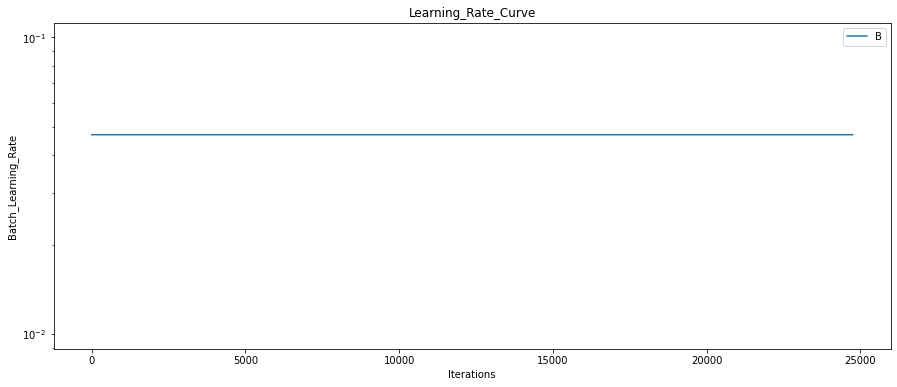

In [23]:
plot_graph(load_path=S15_PROJECT_PATH+'/Save_Model/'+name+'_stats.json', cols=["batch_lr"], legend_arr='Batch_Learning_Curve', xlabel='Iterations', ylabel='Batch_Learning_Rate', title='Learning_Rate_Curve', save_path=S15_PROJECT_PATH+'/Save_Model/',log=True)

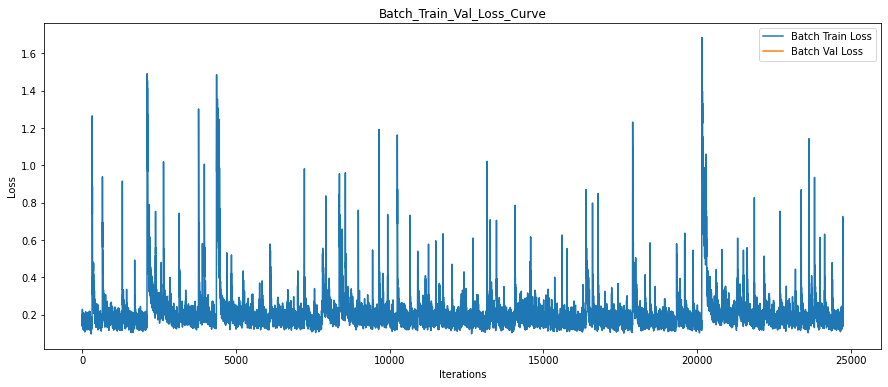

In [24]:
plot_graph(load_path=S15_PROJECT_PATH+'/Save_Model/'+name+'_stats.json', cols=["batch_train_loss", "batch_val_loss"], legend_arr=['Batch Train Loss', 'Batch Val Loss'], xlabel='Iterations', ylabel='Loss', title='Batch_Train_Val_Loss_Curve', save_path=S15_PROJECT_PATH+'/Save_Model/')

In [0]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# model = Resnet_Architecture(Model_Layers=18, name="Model_Res", num_classes=200)
# model.to(dataloader.device)
# Loss="CrossEntropyLoss"
# EPOCHS = 30
# model.device=dataloader.device
# optimizer = optim.SGD(model.parameters(), lr=0.100174454672119, weight_decay=0.0019 ,momentum=0.9)
# #scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True, min_lr=1e-5)
# #scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.100174454672119, steps_per_epoch=len(trainloader), epochs=EPOCHS,  pct_start=5/EPOCHS, div_factor=100, final_div_factor=8)
# model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, dataloader=dataloader, epochs=EPOCHS, statspath=S15_PROJECT_PATH+"/Save_Model/", scheduler=scheduler, batch_scheduler=True, L1lambda=0, LossType=Loss)

In [0]:
#class_acurracy(model, model.device, testloader, classes)

In [0]:
#MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels = get_classified_images(model, model.device, testloader, classification='Miss')

In [0]:
#CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels = get_classified_images(model, model.device, testloader, classification='Corr')

In [0]:
#cols = ["batch_train_loss", "batch_train_acc", "batch_lr","avg_test_loss", "test_acc", "train_acc", "avg_train_loss", "lr", "best_test_loss", "epochs"]
#plot_graph(load_path=S15_PROJECT_PATH+'/Save_Model/Model_Res_stats.json', cols=["test_acc", "train_acc"], legend_arr=['Test Accuracy', 'Train Accuracy'], xlabel='Epochs', ylabel='Accuracy', title='Accuracy_Curve', save_path=S15_PROJECT_PATH+'/Save_Model/')

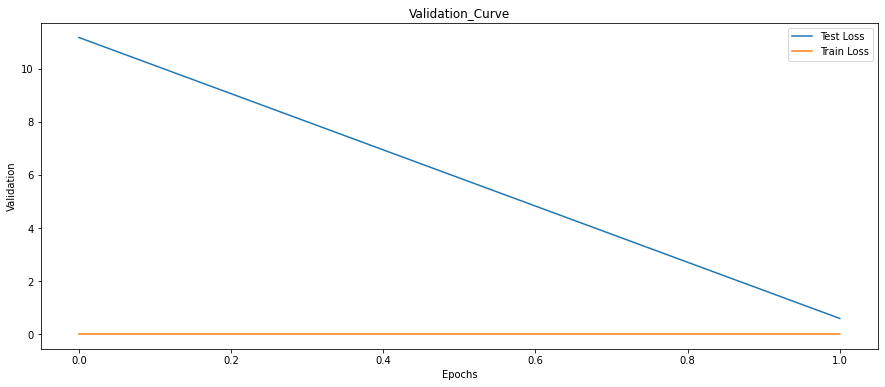

In [25]:
plot_graph(load_path=S15_PROJECT_PATH+'/Save_Model/'+name+'_stats.json', cols=["avg_test_loss","avg_train_loss"], legend_arr=['Test Loss', 'Train Loss'], xlabel='Epochs', ylabel='Validation', title='Validation_Curve', save_path=S15_PROJECT_PATH+'/Save_Model/')

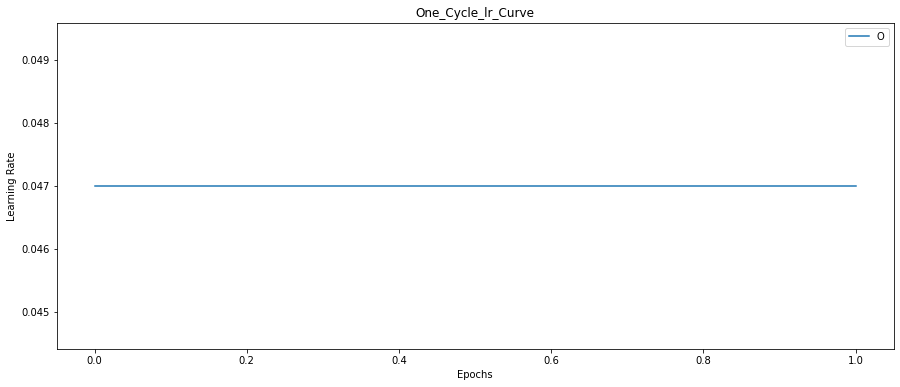

In [26]:
plot_graph(load_path=S15_PROJECT_PATH+'/Save_Model/'+name+'_stats.json', cols=["lr"], legend_arr="One-Cycle Learning Rate", xlabel='Epochs', ylabel='Learning Rate', title='One_Cycle_lr_Curve', save_path=S15_PROJECT_PATH+'/Save_Model/')

In [0]:
#show_classified(MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels, classes, mean, std,"Mis-classified Images",S15_PROJECT_PATH+'/Save_Model/',25)

In [0]:
#show_classified(CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels, classes, mean, std,"Corr-classified Images",S15_PROJECT_PATH+'/Save_Model/',25)

In [0]:
# from GradCam import VisualizeCam
# target_layers = ["resnet_arch.layer1", "resnet_arch.layer2", "resnet_arch.layer3", "resnet_arch.layer4"]
# viz_cam = VisualizeCam(model, classes, target_layers)

In [0]:
# viz_cam(MisClassifiedImages[:25], MisClassifiedTargLabels[:25], target_layers, mean, std, target_inds=MisClassifiedTargLabels[:25], metric="Incorrect", per_image=False, path=S15_PROJECT_PATH+"/Save_Model/")

In [0]:
#viz_cam(CorrClassifiedImages[:25], CorrClassifiedTargLabels[:25], target_layers, mean, std, target_inds=None, metric="Correct", per_image=False, path=S15_PROJECT_PATH+"/Save_Model/")

In [27]:
%cp -av /content/tensorboard/ '{S15_PROJECT_PATH}/Save_Data/'

'/content/tensorboard/' -> '/content/drive/My Drive/Colab Notebooks/S15/Save_Data/tensorboard'
'/content/tensorboard/Model_Unet_Exp5' -> '/content/drive/My Drive/Colab Notebooks/S15/Save_Data/tensorboard/Model_Unet_Exp5'
'/content/tensorboard/Model_Unet_Exp5/events.out.tfevents.1590350730.984a51038bc0.136.0' -> '/content/drive/My Drive/Colab Notebooks/S15/Save_Data/tensorboard/Model_Unet_Exp5/events.out.tfevents.1590350730.984a51038bc0.136.0'
